# Churn Prediction


Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The raw data contains 7043 rows (customers) and 21 columns (features).

The “Churn” column is our target.

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn 
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100) 

# EDA

In [2]:
# Read data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
Churn               7043 non-null int64
dtypes: float64(1), int64(3), object(15)
memory usage: 1.0+ MB


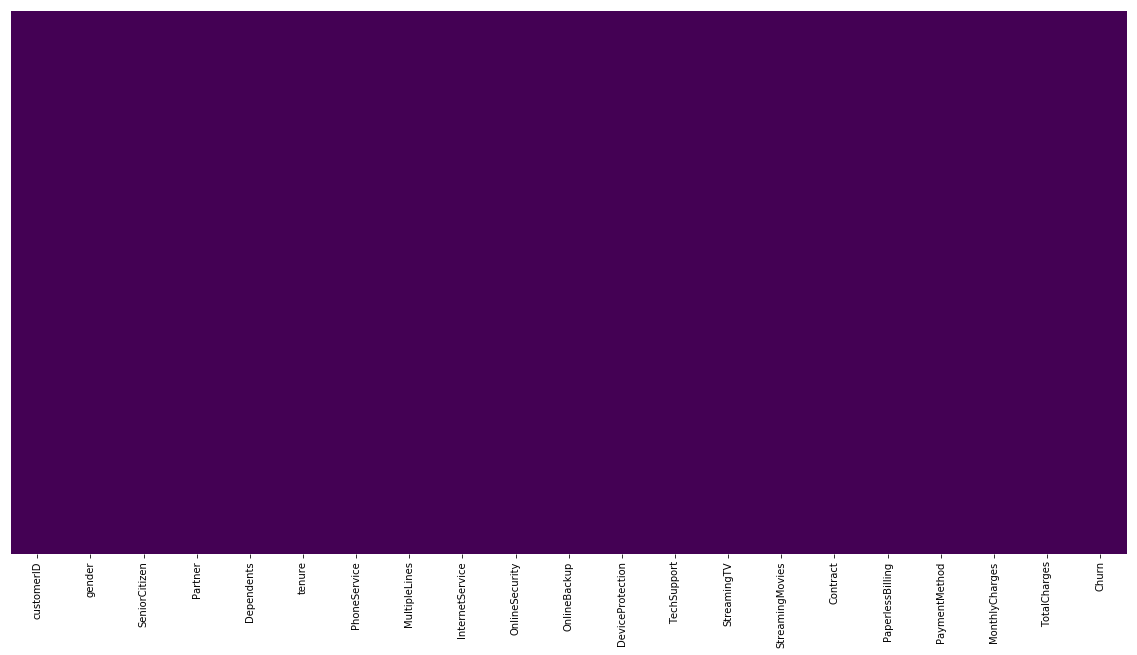

In [9]:
# Check for missing values
plt.figure(figsize=(20,10))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [10]:
# Count missing values
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Series([], dtype: float64)

In [11]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


### Distribution of target variable:  Churn

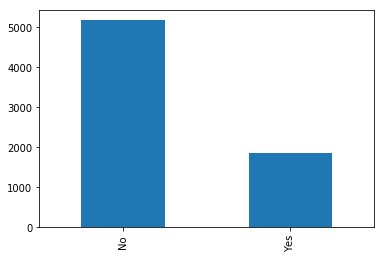

In [12]:
df['Churn'].value_counts().plot(kind="bar")
plt.show()

In [13]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [14]:
ratio = 1869/5174
print(ratio)

0.36122922303826827


In [15]:
class1 = df[df['Churn'] == 1]['Churn'].count()
class0 = df[df['Churn'] == 0]['Churn'].count()

In [16]:
class_weight_1 = class1 / (class1 + class0)
class_weight_0 = class0 / (class1 + class0)

Resampling is not required. The ratio is 36%

## Check for duplicates of customerID 

In [17]:
df.duplicated('customerID').sum()

0

In [18]:
# drop customerID
df.drop('customerID',axis=1,inplace=True)

### Check amount of numerical and categorical features 

In [36]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))


Number of Numerical features:  4
Number of Categorical features:  15


In [37]:
# Get values of categorical features
categorical_feats = df.dtypes[df.dtypes == "object"].index
for catg in list(categorical_feats) :
    print(df [catg].value_counts())
    print('-'*50)

Male      3555
Female    3488
Name: gender, dtype: int64
--------------------------------------------------
No     3641
Yes    3402
Name: Partner, dtype: int64
--------------------------------------------------
No     4933
Yes    2110
Name: Dependents, dtype: int64
--------------------------------------------------
Yes    6361
No      682
Name: PhoneService, dtype: int64
--------------------------------------------------
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
--------------------------------------------------
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
--------------------------------------------------
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
--------------------------------------------------
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBa

Nominal features:
- gender (binary)
- Partner (binary)
- Dependents (binary)
- PhoneService 
- MultipleLines
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport
- StreamingTV
- StreamingMovies
- Contract
- PaperlessBilling (binary)
- PaymentMethod

In [40]:
# Transform TotalCharges into float
df.TotalCharges = pd.to_numeric(df.MonthlyCharges, errors='coerce')

In [50]:
sum(df.TotalCharges.isnull())

0

In [51]:
# Fill NaN values with mean
from sklearn.preprocessing import Imputer

In [61]:
imr = Imputer(missing_values='NaN',strategy='mean',axis=0)
imr.fit(df.TotalCharges.values.reshape(-1, 1))

imputed_data = imr.transform(df.TotalCharges.values.reshape(-1, 1))
df['TotalCharges'] = imputed_data

In [64]:
sum(df.TotalCharges.isnull())

0

### Check distributions of numerical features 

Skewness: -0.220524
Kurtosis: -1.257260


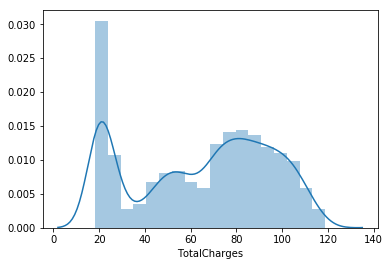

In [65]:
sns.distplot(df['TotalCharges']);
#skewness and kurtosis
print("Skewness: %f" % df['TotalCharges'].skew())
print("Kurtosis: %f" % df['TotalCharges'].kurt())

Skewness: -0.220524
Kurtosis: -1.257260


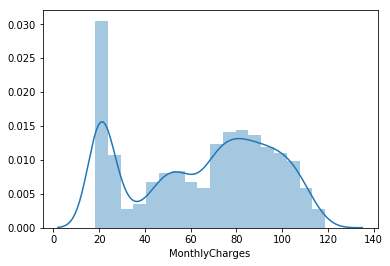

In [66]:
sns.distplot(df['MonthlyCharges']);
#skewness and kurtosis
print("Skewness: %f" % df['MonthlyCharges'].skew())
print("Kurtosis: %f" % df['MonthlyCharges'].kurt())

Skewness: 0.239540
Kurtosis: -1.387372


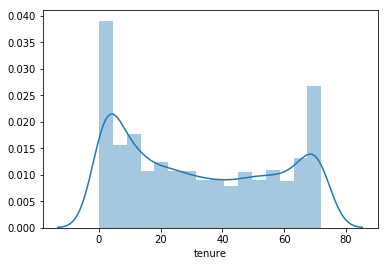

In [67]:
sns.distplot(df['tenure']);
#skewness and kurtosis
print("Skewness: %f" % df['tenure'].skew())
print("Kurtosis: %f" % df['tenure'].kurt())

In [68]:
# Check if TotalCharges is 'tenure' * 'MontlyCharges'
df['tenure*monthlypay'] = df['tenure'] * df['MonthlyCharges']

In [69]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,TotalCharges,tenure*monthlypay
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,0,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,0,56.95,1936.30
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,1,53.85,107.70
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,0,42.30,1903.50
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,1,70.70,141.40


Conclusion: TotalCharges is simply the tenure * MonthlyCharges. Hence it does not add valuable information. Therefore it will be dropped

In [70]:
todrop = ['tenure*monthlypay', 'TotalCharges']
df.drop(todrop, inplace=True, axis=1)

### Encoding binary and nominal features 

All categorical features are either binary or nominal. No feature is ordinal.

In [71]:
# Convert class labels to integers: Yes = 1, No = 0
class_mapping = {label: idx for idx,label in enumerate(np.unique(df['Churn']))}

In [72]:
df['Churn'] = df['Churn'].map(class_mapping)

------------------------------------------------------------------------------------------------------

In [73]:
categorical_feats = df.dtypes[df.dtypes == "object"].index

In [74]:
categorical_feats

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'], dtype='object')

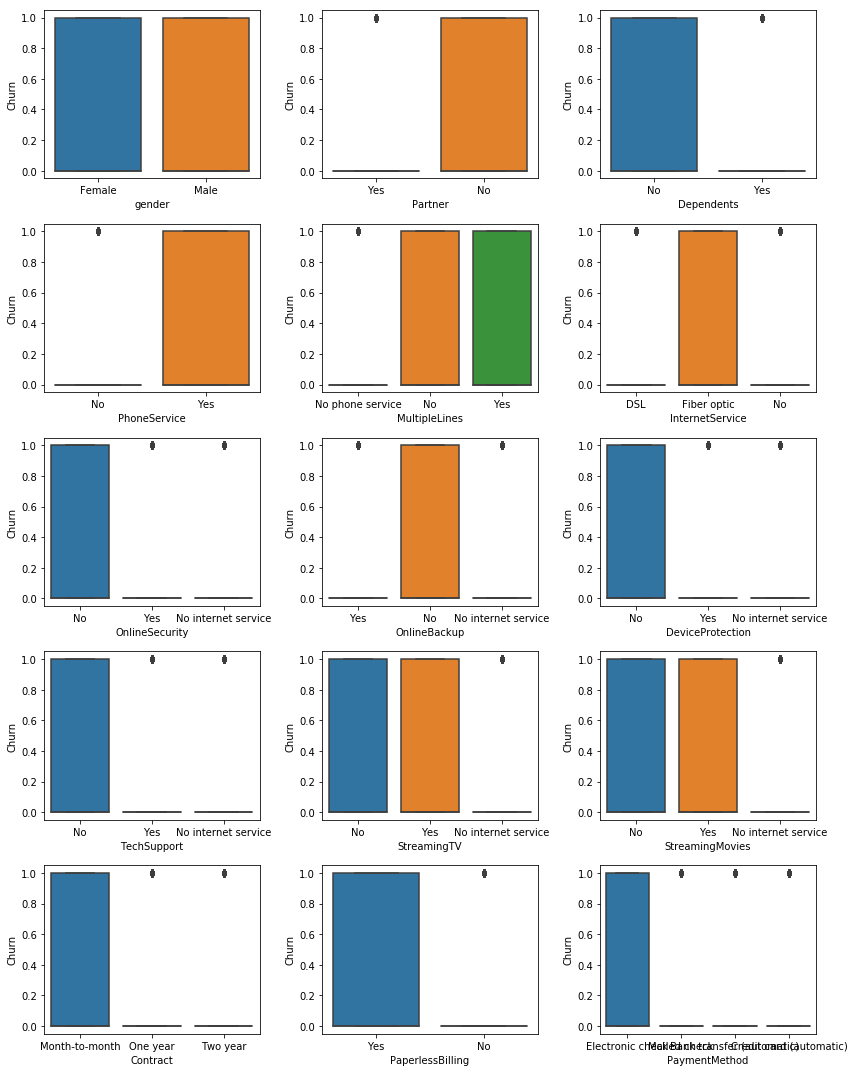

In [75]:
li_cat_feats = list(categorical_feats)
nr_rows = 5
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=df['Churn'], data=df, ax = axs[r][c])
            
    
plt.tight_layout()
plt.show()   

In [76]:
# Get dummies
df_dummies = pd.get_dummies(df[['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']],drop_first = True)

In [77]:
# Merge with old dataframe
df = pd.merge(df_dummies, df, left_index=True, right_index=True)

In [78]:
# Drop non-dummy columns
columns_todrop = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
df.drop(columns_todrop, inplace=True, axis=1)

In [79]:
df.head(10)

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen,tenure,MonthlyCharges,Churn
0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,29.85,0
1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,34,56.95,0
2,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,53.85,1
3,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,45,42.30,0
4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,70.70,1
5,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,8,99.65,1
6,1,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,22,89.10,0
7,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,10,29.75,0
8,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,28,104.80,1
9,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,62,56.15,0


### Standardize numerical features 

In [80]:
# Features to be standardized: tenure and MonthlyCharges

In [81]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [82]:
scaled_features = scaler.fit_transform(df[['tenure','MonthlyCharges']])
scaled_df = pd.DataFrame(scaled_features, columns=['tenure','MonthlyCharges'])

In [83]:
# Merge scaled_df with normal df
df = pd.merge(scaled_df, df, left_index=True, right_index=True)

In [84]:
# Drop non-standardized features
df.head(5)

,tenure_x,MonthlyCharges_x,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen,tenure_y,MonthlyCharges_y,Churn
0,-1.277445,-1.160323,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,29.85,0
1,0.066327,-0.259629,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,34,56.95,0
2,-1.236724,-0.362660,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,53.85,1
3,0.514251,-0.746535,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,45,42.30,0
4,-1.236724,0.197365,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,70.70,1


In [85]:
# Drop non-dummy columns
df.drop(['tenure_y','MonthlyCharges_y'], inplace=True, axis=1)

## Feature selection 

Drop features that don't correlate with Churn. Subsequently plot feature importance with random forest

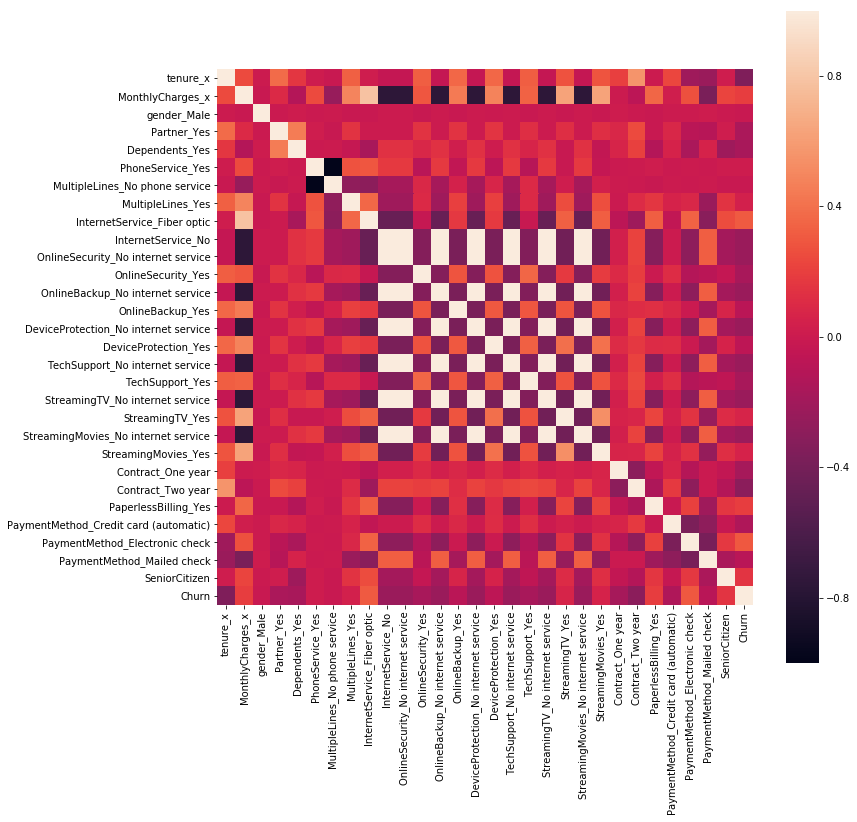

In [86]:
corr = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1, square=True)
plt.show()

In [87]:
# target used for correlation 
target = 'Churn'

Churn                                   1.000000
tenure_x                                0.352229
InternetService_Fiber optic             0.308020
Contract_Two year                       0.302253
PaymentMethod_Electronic check          0.301919
InternetService_No                      0.227890
OnlineSecurity_No internet service      0.227890
OnlineBackup_No internet service        0.227890
DeviceProtection_No internet service    0.227890
TechSupport_No internet service         0.227890
StreamingTV_No internet service         0.227890
StreamingMovies_No internet service     0.227890
MonthlyCharges_x                        0.193356
PaperlessBilling_Yes                    0.191825
Contract_One year                       0.177820
OnlineSecurity_Yes                      0.171226
TechSupport_Yes                         0.164674
Dependents_Yes                          0.164221
SeniorCitizen                           0.150889
Partner_Yes                             0.150448
Name: Churn, dtype: 

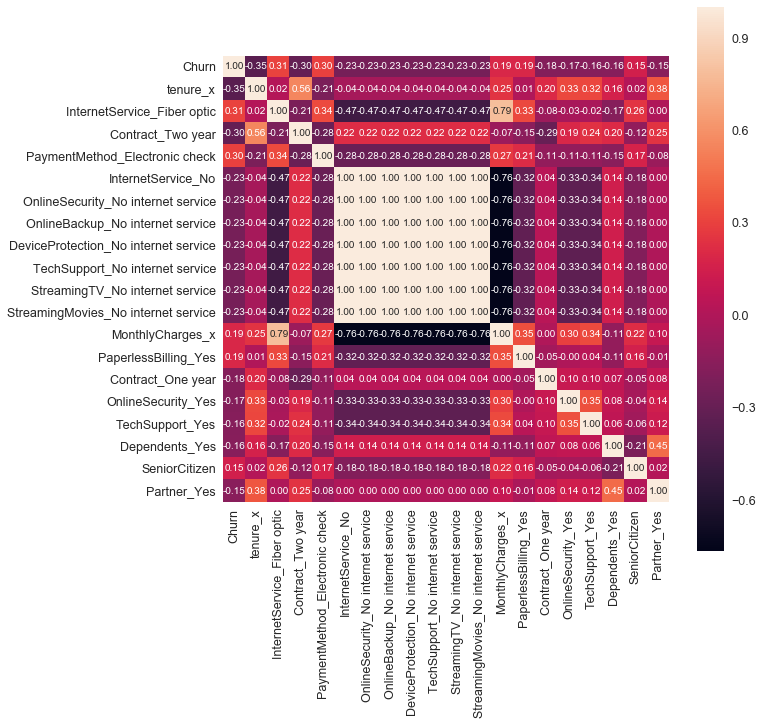

In [88]:
# top ten highest correlated numerical features
nr_feats = 20

corr_abs = corr.abs()
print (corr_abs.nlargest(nr_feats, target)[target])

cols = corr_abs.nlargest(nr_feats, target)[target].index
cm = np.corrcoef(df[cols].values.T)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Feature importance with random forest 

In [89]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [90]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

 1) MonthlyCharges_x               0.241458
 2) gender_Male                    0.220656
 3) PaymentMethod_Mailed check     0.041890
 4) InternetService_No             0.040826
 5) PaperlessBilling_Yes           0.035851
 6) Partner_Yes                    0.034214
 7) PaymentMethod_Credit card (automatic) 0.030622
 8) StreamingTV_No internet service 0.028556
 9) Dependents_Yes                 0.027749
10) DeviceProtection_No internet service 0.027536
11) OnlineBackup_No internet service 0.027485
12) Contract_Two year              0.027409
13) Churn                          0.025346
14) InternetService_Fiber optic    0.024857
15) TechSupport_No internet service 0.023825
16) PhoneService_Yes               0.023394
17) Contract_One year              0.021245
18) StreamingMovies_No internet service 0.020873
19) PaymentMethod_Electronic check 0.016643
20) SeniorCitizen                  0.014822
21) OnlineSecurity_Yes             0.005568
22) MultipleLines_Yes              0.005348
23) Device

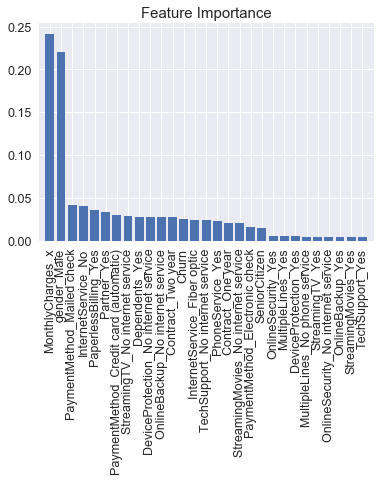

In [91]:
# Feature importance with Random Forest
from sklearn.ensemble import RandomForestClassifier

feat_labels = df.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.figure(figsize=(20,5))
plt.show()

# Training ML models and evaluation

Classifier algorithms to test:

1. Logistic Regression with regularization

2. DecisionTree Classifier

3. Random Forest Classifier

4. AdaBoost (tree) Classifier

5. XGBoost

Because we are dealing with an imbalanced dataset (more churn than no-churn), evaluating a model with accuracy is misleading. Therefore precision and recall is used. 

- Precision is a measure of accuracy achieved in positive prediction. In other words, when it predicts yes, how often is it correct?

Precision = True Positives / Predicted Positives

- Recall (also known as sensitivity) is a measure of actual observations, which are predicted correctly. In other words, when it’s actually yes, how often does it predict yes? 

Recall = True Positives / Actual Positives

In [92]:
from sklearn.model_selection import GridSearchCV

## 1. Logistic Regression 

In [93]:
# Base model
from sklearn.linear_model import LogisticRegression

In [94]:
lr = LogisticRegression(class_weight={0:class_weight_1, 1:class_weight_0})

In [ ]:
lr.fit(X_train,y_train)

In [ ]:
lr_base_pred = lr.predict(X_test)

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, lr_base_pred)
print(cm)


plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,lr_base_pred))
print(confusion_matrix(y_test, lr_base_pred))

### Hyperparameter tuning 

In [ ]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
parameters = dict(C=C, penalty=penalty)

In [ ]:
# Instantiate the grid search model
grid_lr = GridSearchCV(LogisticRegression(class_weight={0:class_weight_1, 1:class_weight_0}), parameters, cv=10, verbose=1, scoring = 'recall')

# Fit the grid search model
grid_lr.fit(X_train, y_train)

print(grid_lr.best_score_)
print(grid_lr.best_params_)

In [ ]:
best_lr = LogisticRegression(class_weight={0:class_weight_1, 1:class_weight_0},penalty='l2',C=2.7825594022071245)

In [ ]:
best_lr.fit(X_train,y_train)

In [ ]:
lr_best_pred = best_lr.predict(X_test)

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, lr_best_pred)
print(cm)


plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
print(classification_report(y_test,lr_best_pred))
print(confusion_matrix(y_test, lr_best_pred))

In [ ]:
# plot ROC curve
# calculate the fpr and tpr for all thresholds of the classification
probs = best_lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',label='random guessing')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve


best_lr = LogisticRegression(class_weight={0:class_weight_1, 1:class_weight_0},penalty='l2',C=2.7825594022071245)

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=best_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.3, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

The Logistic Regression model has low variance, but a relatively high bias.

## 2. DecisionTree Classifier

In [ ]:
# Base model
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(X_train,y_train)

In [ ]:
dt_base_pred = dt.predict(X_test)

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, dt_base_pred)
print(cm)


plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,dt_base_pred))
print(confusion_matrix(y_test, dt_base_pred))

### Hyperparameter tuning

In [ ]:
parameters = {'max_depth': list(range(1,101))}

In [ ]:
# Instantiate the grid search model
grid_dt = GridSearchCV(DecisionTreeClassifier(class_weight={0:class_weight_1, 1:class_weight_0}), parameters, cv=10, verbose=1, scoring = 'recall')

# Fit the grid search model
grid_dt.fit(X_train, y_train)

print(grid_dt.best_score_)
print(grid_dt.best_params_)

In [ ]:
best_dt = DecisionTreeClassifier(class_weight={0:class_weight_1, 1:class_weight_0},criterion='gini',max_depth=1)

In [ ]:
best_dt.fit(X_train,y_train)

In [ ]:
dt_best_pred = best_dt.predict(X_test)

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, dt_best_pred)
print(cm)


plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
print(classification_report(y_test,dt_best_pred))
print(confusion_matrix(y_test, dt_best_pred))

In [ ]:
# plot ROC curve
# calculate the fpr and tpr for all thresholds of the classification
probs = best_dt.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',label='random guessing')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores =\
                learning_curve(estimator=best_dt,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.3, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

The decision tree classifier has low variance, but a very high bias.

## 3. Random Forest Classifier 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(class_weight={0:class_weight_1, 1:class_weight_0})

In [ ]:
rf.fit(X_train,y_train)

In [ ]:
rf_base_pred = rf.predict(X_test)

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, rf_base_pred)
print(cm)


plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
print(classification_report(y_test,dt_base_pred))
print(confusion_matrix(y_test, dt_base_pred))

### Hyperparameter tuning (RandomizedSearchCV)

In [ ]:
parameters = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt','log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight={0:class_weight_1, 1:class_weight_0})
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
random_rf = RandomizedSearchCV(estimator = rf, param_distributions = parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
random_rf.fit(X_train, y_train)

print(random_rf.best_score_)
print(random_rf.best_params_)

In [ ]:
best_rf = RandomForestClassifier(class_weight={0:class_weight_1, 1:class_weight_0},n_estimators=1600,min_samples_split=5,min_samples_leaf=1,max_features='log2',max_depth=80,bootstrap=True)

In [ ]:
best_rf.fit(X_train,y_train)

In [ ]:
rf_best_pred = best_rf.predict(X_test)

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, rf_best_pred)
print(cm)


plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
print(classification_report(y_test,rf_best_pred))
print(confusion_matrix(y_test, rf_best_pred))

In [ ]:
# plot ROC curve
# calculate the fpr and tpr for all thresholds of the classification
probs = best_rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',label='random guessing')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=best_rf,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.3, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

The Random forest classifier has high variance, but low bias.

## 4. AdaBoost (tree) Classifier 

The AdaBoost (Adaptive Boosting) Classifier draws a random subset of training samples, without replacement to a weak learner. Subsquently, it adds 50% of the misclassified samples in the previous iteration. 

It focusses on training samples that are hard to classify and let the weak learners subsequently learn from misclassified training samples to improve the performance.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
adaboost = AdaBoostClassifier(base_estimator=best_dt)

In [ ]:
adaboost.fit(X_train,y_train)

In [ ]:
adaboost_base_pred = adaboost.predict(X_test)

In [ ]:
cm = metrics.confusion_matrix(y_test, adaboost_base_pred)
print(cm)


plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
print(classification_report(y_test,adaboost_base_pred))
print(confusion_matrix(y_test, adaboost_base_pred))

### Hyperparameter tuning 

In [ ]:
parameters = {
'learning_rate':[0.01,0.03,0.05,0.1],
'n_estimators':[50, 100,200,500,1000]}

In [ ]:
# Instantiate the grid search model
grid_adaboost = GridSearchCV(adaboost, parameters, cv=10, verbose=1, scoring = 'recall')
# Fit the grid search model
grid_adaboost.fit(X_train, y_train)

print(grid_adaboost.best_score_)
print(grid_adaboost.best_params_)

In [ ]:
best_adaboost = AdaBoostClassifier(base_estimator=best_dt,learning_rate=0.01,n_estimators=50)

In [ ]:
best_adaboost.fit(X_train,y_train)

In [ ]:
adaboost_best_pred = best_adaboost.predict(X_test)

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, adaboost_best_pred)
print(cm)


plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
print(classification_report(y_test,adaboost_best_pred))
print(confusion_matrix(y_test, adaboost_best_pred))

In [ ]:
# plot ROC curve
# calculate the fpr and tpr for all thresholds of the classification
probs = best_adaboost.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',label='random guessing')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=best_adaboost,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.3, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

The Adaboost classifier with decision tree has low variance, but high bias.

## 5. XGBoost 

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier()

In [ ]:
xgb.fit(X_train,y_train)

In [ ]:
xgb_base_pred = xgb.predict(X_test)

In [ ]:
cm = metrics.confusion_matrix(y_test, xgb_base_pred)
print(cm)


plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
print(classification_report(y_test,xgb_base_pred))
print(confusion_matrix(y_test, xgb_base_pred))

### Hyperparameter tuning 

In [ ]:
parameters = {
 'max_depth':[2, 4, 6, 8],
'learning_rate':[0.01,0.03,0.05],
'n_estimators':[50, 100, 200,1000]
}

In [ ]:
# Instantiate the grid search model
grid_xgboost = GridSearchCV(XGBClassifier(), parameters, cv=10, verbose=1, scoring = 'recall')
# Fit the grid search model
grid_xgboost.fit(X_train, y_train)

print(grid_xgboost.best_score_)
print(grid_xgboost.best_params_)

In [ ]:
best_xgboost = XGBClassifier(max_depth=4,learning_rate=0.05,n_estimators=1000)

In [ ]:
best_xgboost.fit(X_train,y_train)

In [ ]:
xgboost_best_pred = best_xgboost.predict(X_test)

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, xgboost_best_pred)
print(cm)


plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [ ]:
print(classification_report(y_test,xgboost_best_pred))
print(confusion_matrix(y_test, xgboost_best_pred))

In [ ]:
# plot ROC curve
# calculate the fpr and tpr for all thresholds of the classification
probs = best_xgboost.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',label='random guessing')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=best_xgboost,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.3, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

# Evaluate

In [ ]:
# Evaluate different models on F1-score
from sklearn.metrics import f1_score

In [ ]:
lr_f1 = f1_score(y_test, lr_best_pred, average='weighted')  
dt_f1 = f1_score(y_test, dt_best_pred, average='weighted')  
rf_f1 = f1_score(y_test, rf_best_pred, average='weighted')  
adaboost_f1 = f1_score(y_test, adaboost_best_pred, average='weighted')  
xgboost_f1 = f1_score(y_test, xgboost_best_pred, average='weighted')  

In [ ]:
# Comparison of MSE of the models
f1_scores = [lr_f1,dt_f1,rf_f1,adaboost_f1,xgboost_f1]
models = ['Logistic Regression','Decision Tree', 'Random Forest','AdaBoost Classifier','XGBoost']
plt.figure(figsize=(10,8))
plt.ylim(0.4, 1.05)
sns.barplot(models,f1_scores,palette='husl')
print(f1_scores)

In [ ]:
# Evaluate different models on AUC score
from sklearn.metrics import roc_auc_score

In [ ]:
lr_auc = roc_auc_score(y_test, lr_best_pred)  
dt_auc = roc_auc_score(y_test, dt_best_pred)  
rf_auc = roc_auc_score(y_test, rf_best_pred)  
adaboost_auc = roc_auc_score(y_test, adaboost_best_pred)  
xgboost_auc = roc_auc_score(y_test, xgboost_best_pred)  

In [ ]:
# Comparison of MSE of the models
auc_scores = [lr_auc,dt_auc,rf_auc,adaboost_auc,xgboost_auc]
models = ['Logistic Regression','Decision Tree', 'Random Forest','AdaBoost Classifier','XGBoost']
plt.figure(figsize=(10,8))
plt.ylim(0, 1.1)
sns.barplot(models,f1_scores,palette='husl')
print(auc_scores)